In [39]:
import copy
import sys
import time
sys.path.append('/home/diego/python/generative-glm/experiments/')

import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from torch.optim import Adam

from gglm.kernels import ker_schoenberg
from gglm.glm.mmdglm import MMDGLM
from gglm.glm.torchglm import TorchGLM
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from gglm.metrics import bernoulli_log_likelihood_poisson_process, MMD
from kernel.values import KernelBasisValues
from gglm.metrics import time_rescale_transform

import myplt

%load_ext autoreload
%autoreload 2

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

from nips2 import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


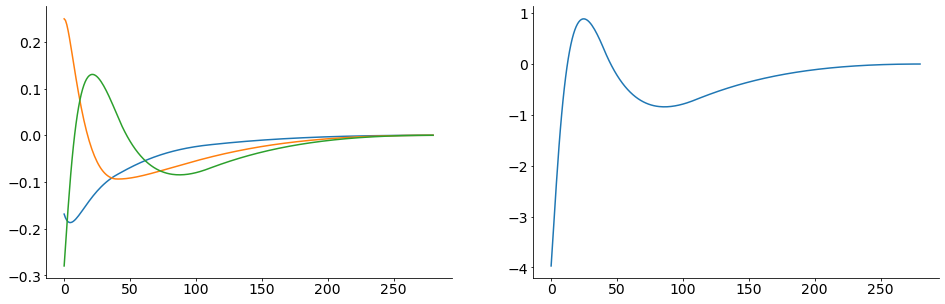

In [40]:
dt = 1
n, last_peak = 3, 40
eta_true = KernelBasisValues.orthogonalized_raised_cosines(dt, last_peak, n, 8, a=1, coefs=np.array([4., -2., 10.]))
t_ker = np.arange(0, eta_true.basis_values.shape[0], 1) * dt
basis = eta_true.basis_values.copy()

fig, (ax1, ax2) = plt.subplots(figsize=(16, 5), ncols=2)
ax1.plot(t_ker, basis)
eta_true.plot(t=t_ker, ax=ax2)

## define gqm and sample

7.06


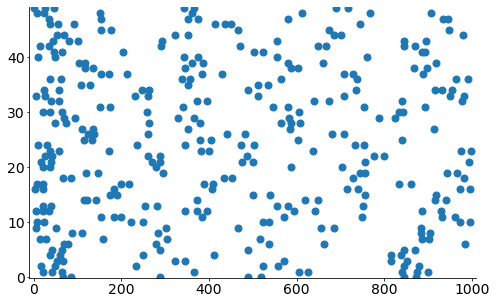

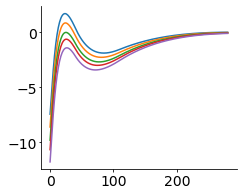

In [41]:
eta = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([4., -2., 12.]))
eta.coefs[-1] = 20.

def gqm_filter(t, dt_last):
    return eta.interpolate(t) - 5 * np.exp(-dt_last / 200) * np.exp(-t / 75)

dt = 1
t = np.arange(0, 1000, 1)
u0 = -4.1

np.random.seed(0)

n = 50
shape = (len(t), n)

r = np.zeros(shape) * np.nan
eta_conv = np.zeros(shape)
mask_spikes = np.zeros(shape, dtype=bool)
last = [None] * n

j = 0
while j < len(t):

    r[j, ...] = np.exp(eta_conv[j, ...] + u0)

    p_spk = 1. - np.exp(-r[j, ...] * dt)
    aux = np.random.rand(*shape[1:])

    mask_spikes[j, ...] = p_spk > aux

    for sw in range(mask_spikes.shape[1]):
        if mask_spikes[j, sw]:
            if last[sw] is None:
                eta_conv[j + 1:, sw] += gqm_filter(t[j + 1:] - t[j + 1], 5000)
            else:
                eta_conv[j + 1:, sw] += gqm_filter(t[j + 1:] - t[j + 1], t[j + 1] - t[last[sw]])
            last[sw] = j

    j += 1

print(np.mean(np.sum(mask_spikes, 0)))
st = SpikeTrain(t, mask_spikes)
n_spk = np.sum(mask_spikes)
fr = np.mean(np.sum(mask_spikes, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes)
isi = st.isi_distribution()
mean_isi = np.mean(isi)
st.plot()

_t = np.arange(0, basis.shape[0], 1)
fig, ax = plt.subplots()
for dt in [400, 200, 100, 50, 0]:
    y = gqm_filter(_t, dt)
    ax.plot(_t, y)

 epoch 1499 of 1500 loss 1856.7757

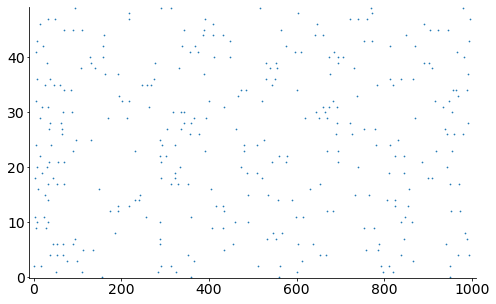

In [27]:
lr = 5e-1
num_epochs = 1500
metrics_kwargs = dict(n_batch_fr=60)
n_metrics = 10

u00 = -4.1
eta0 = eta.copy()

glm = TorchGLM(u0=u00, eta=eta0.copy(), noise='bernoulli')
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st.t, st.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=None)
loss_ml = np.array(loss_ml)
iterations_ml = np.arange(1, num_epochs + 1, 1)
nll_normed_ml = (loss_ml - nll_pois_proc_train) / np.log(2) / n_spk

_, r_dc_ml = glm.sample_conditioned(st.t, st.mask)
_, _, mask_spikes_ml = glm.sample(st.t, shape=(st.mask.shape[1], ))
st_fr_ml = SpikeTrain(st.t, mask_spikes_ml)
st_fr_ml.plot(ms=0.7)

In [28]:
# idx_fr = np.triu_indices(mask_spikes_ml.shape[1], k=1)
# idx_fr = (torch.from_numpy(idx_fr[0]), torch.from_numpy(idx_fr[1]))
# idx_d = np.triu_indices(mask_spikes.shape[1], k=1)
# idx_d = (torch.from_numpy(idx_d[0]), torch.from_numpy(idx_d[1]))

# mmd_ml = []
# # mmd_mmd = []

# sd2_l = [1e0, 1e1, 1e2, 2e2, 5e2, 7e2, 1e3, 5e3, 1e4]
# # sd2_l = [4e2, 5e2, 6e2, 7e2, 8e2, 9e2, 1e3]
# # sd2_l = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
# biased = False
# for ii, _sd2 in enumerate(sd2_l):
#     _, _, mask_spikes_ml = glm.sample(st.t, shape=(800, ))
    
#     gramian_d_d = ker(t, torch.from_numpy(mask_spikes), torch.from_numpy(mask_spikes), _sd2)
#     gramian_fr_fr = ker(t, torch.from_numpy(mask_spikes_ml), torch.from_numpy(mask_spikes_ml), _sd2)
#     gramian_d_fr = ker(t, torch.from_numpy(mask_spikes), torch.from_numpy(mask_spikes_ml), _sd2)

#     if not biased:
#         _mmd_ml = torch.mean(gramian_d_d.detach()[idx_d]) + torch.mean(gramian_fr_fr.detach()[idx_fr]) \
#                           - 2 * torch.mean(gramian_d_fr.detach())
#     else:
#         _mmd_ml = torch.mean(gramian_d_d.detach()) + torch.mean(gramian_fr_fr.detach()) \
#                           - 2 * torch.mean(gramian_d_fr.detach())
#     mmd_ml.append(_mmd_ml.item())
#     print(ii, _sd2, _mmd_ml.item())
# #     print(np.mean(mmd_ml))
# print(mmd_ml)

In [29]:
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    T = st.t[-1] - st.t[0] + st.t[1]
    u_dc, r_dc = model.sample_conditioned(st.t, st.mask)
    nll = -(np.sum(np.log(1 - np.exp(-dt * r_dc[st.mask]) + 1e-24) ) - \
                dt * np.sum(r_dc[~st.mask]))
    return dict(nll=nll)

### MMD

In [35]:
# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e0, False, 1e-2, 1e0, 1e4 #1st

# phi, kernel, biased, lr, clip, sd2 = None, ker_sch_heavi, True, 2e-3, 1e0, 5e2

# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e0, False, 2e-3, 1e0, 1e3 #1st

# phi, kernel, biased, lr, sd2 = None, ker_sch_heavi, False, 5e-3, 7e2
# phi, kernel, biased, lr, sd2 = None, ker_sch_heavi, False, 5e-3, 2e2

phi, kernel, biased, lr, kernel_kwargs = None, ker_schoenberg, False, 1e-2, dict(sd2=7e2)

# phi, kernel, biased, lr, kernel_kwargs = None, ker_schoenberg, False, 1e-2, dict(sd2=5e3)

clip = None

beta0, beta1 = 0, 0
n_batch_fr = 200
num_epochs = 400
n_metrics = 1

u00 = glm.u0
eta0 = glm.eta.copy()

mmdglm = MMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))
scheduler = None

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes), phi=phi, kernel=kernel, 
                                                log_likelihood=False, kernel_kwargs=kernel_kwargs, 
                                              n_batch_fr=n_batch_fr, biased=biased, optim=optim, clip=clip, 
                                                num_epochs=num_epochs, scheduler=scheduler, 
                                              verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_mmd = (metrics_mmd['nll'] - nll_pois_proc_train) / np.log(2) / n_spk
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st.t, shape=(st.mask.shape[1],))
st_fr_mmd = SpikeTrain(st.t, mask_spikes_fr_mmd)

 epoch 399 of 400 loss 0.13716031818

In [36]:
mmd_ml = []
for ii in range(20):
    _, r_fr_ml, mask_spikes_fr_ml = glm.sample(st.t, shape=(n_batch_fr,))
    _mmd_ml = MMD(t, torch.from_numpy(st.mask), torch.from_numpy(mask_spikes_fr_ml), phi=None, kernel=ker_schoenberg, biased=biased, **kernel_kwargs).item()
    mmd_ml.append(_mmd_ml)

mean_mmd_ml = np.mean(mmd_ml)
sd_mmd_ml = np.std(mmd_ml)
se_mmd_ml = sd_mmd_ml / len(mmd_ml)

### plot

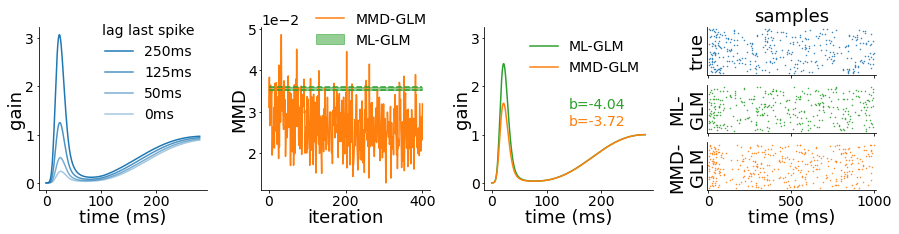

In [37]:
nrows, ncols = 3, 4

fig = plt.figure(figsize=(20 * 0.75, 4 * 0.75))
ax2 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=nrows)
ax1 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=nrows)
ax3 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=nrows, sharex=ax2, sharey=ax2)
ax4 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=1)
ax5 = plt.subplot2grid((nrows, ncols), (1, 3), rowspan=1, sharex=ax4)
ax6 = plt.subplot2grid((nrows, ncols), (2, 3), rowspan=1, sharex=ax4)

ax1.plot(iterations_mmd, metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
ax1.plot([1, num_epochs], [mean_mmd_ml - se_mmd_ml, mean_mmd_ml - se_mmd_ml], '--', color=palette['ml'])
ax1.plot([1, num_epochs], [mean_mmd_ml + se_mmd_ml, mean_mmd_ml + se_mmd_ml], '--', color=palette['ml'])
ax1.fill_between([1, num_epochs], mean_mmd_ml - se_mmd_ml, mean_mmd_ml + se_mmd_ml, alpha=0.5, label='ML-GLM', color=palette['ml'])
ax1.set_xlabel('iteration')
ax1.set_ylabel('MMD')
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1.legend(frameon=False, bbox_to_anchor=(0.25, 0.8, 0.2, 0.2))

# ax2.plot([1, num_epochs], [nll_normed_ml[-1], nll_normed_ml[-1]], '--', label='ML-GLM', color=palette['ml'])
# ax2.plot(iterations_mmd, nll_normed_mmd, label='MMD-GLM', color=palette['mmd'])
# # ax2.plot([1, num_epochs], [mean_mmd_ml - se_mmd_ml, mean_mmd_ml - se_mmd_ml], '--', color=palette['ml'])
# # ax2.plot([1, num_epochs], [mean_mmd_ml + se_mmd_ml, mean_mmd_ml + se_mmd_ml], '--', color=palette['ml'])
# myplt.set_labels(ax2, xlabel='iteration', ylabel='neg log-L (bits/spk)')
# ax2.legend(frameon=False)
# ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

lw = 1.5
glm.eta.plot(t=t_ker, ax=ax3, exp_values=True, lw=lw, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax3, exp_values=True, lw=lw, label='MMD-GLM', color=palette['mmd'])
# eta1.plot(t=t_ker, ax=ax3, exp_values=True, lw=lw, linestyle='--')
# eta2.plot(t=t_ker, ax=ax3, exp_values=True, lw=lw, linestyle='--')
ax3.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax3.transAxes, fontsize=tick_labelsize)
ax3.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax3.transAxes, fontsize=tick_labelsize)
# ax3.set_title('history filter')
ax3.set_xlabel('time (ms)'); ax3.set_ylabel('gain')
ax3.legend(frameon=False)

_t = np.arange(0, basis.shape[0], 1)
# fig, ax = plt.subplots()
for ii, dt in enumerate([250, 125, 50, 0]):
    y = gqm_filter(_t, dt)
    ax2.plot(_t, np.exp(y), alpha=1 - ii * 0.2, color='C0', label=str(dt)+'ms')
ax2.set_xlabel('time (ms)'); ax2.set_ylabel('gain')
ax2.legend(title='lag last spike', frameon=False, title_fontsize=tick_labelsize, loc=1, bbox_to_anchor=(1., 1.1))
    
ms = 1
ax4.set_title('samples')
ax4.set_ylabel('true')
st.plot(ax=ax4, marker='.', ms=ms, color=palette['d'])
st_fr_ml.plot(ax=ax5, marker='.', ms=ms, color=palette['ml'])
st_fr_mmd.plot(ax=ax6, marker='.', ms=ms, color=palette['mmd'])
ax5.set_ylabel('ML-\nGLM')
ax6.set_xlabel('time (ms)')
ax6.set_ylabel('MMD-\nGLM')

ax4.tick_params(axis='x', labelbottom=False)
ax4.set_yticks([])
ax5.set_yticks([])
ax5.tick_params(axis='x', labelbottom=False)
ax6.set_yticks([])

fig.subplots_adjust(wspace=0.32)

# fig.savefig('./fig2b.svg', transparent=True, bbox_inches='tight')
# fig.savefig('./fig2b.pdf', transparent=True, bbox_inches='tight')